<a href="https://colab.research.google.com/github/MatheusDLins/Computacao_Cognitiva/blob/main/Introducao_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Introdução a NLP
Processamento de Linguagem Natural


In [79]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import itertools
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from gensim.models import Phrases
from tensorflow.keras.utils import to_categorical

In [38]:
# Inspecionando os dados 
url = 'https://raw.githubusercontent.com/hundredblocks/concrete_NLP_tutorial/master/socialmedia_relevant_cols.csv'
questions = pd.read_csv(url, encoding='ISO-8859-1')
questions.columns=['text', 'choose_one', 'class_label']

###Dados sujos:


In [39]:
#Primeiras linhas 
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


###Tabela 1


In [40]:
#Últimas linhas
questions.tail()

,text,choose_one,class_label
10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,Relevant,1
10872,Police investigating after an e-bike collided ...,Relevant,1
10873,The Latest: More Homes Razed by Northern Calif...,Relevant,1
10874,MEG issues Hazardous Weather Outlook (HWO) htt...,Relevant,1
10875,#CityofCalgary has activated its Municipal Eme...,Relevant,1


###Estatística descritiva:

In [41]:
questions.describe()

,class_label
count,10876.000000
mean,0.432604
std,0.498420
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


###Método de limpeza:

In [42]:
# Expressões regulares para limpeza dos dados 
def standardize_text(df, text_field):    
    df[text_field] = df[text_field].str.replace(r"http\S+", "")    
    df[text_field] = df[text_field].str.replace(r"http", "")    
    df[text_field] = df[text_field].str.replace(r"@\S+", "")    
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")    
    df[text_field] = df[text_field].str.replace(r"@", "at")    
    df[text_field] = df[text_field].str.lower()    
    return df

In [43]:
#Limpeza e regravação do arquivo de saída limpo 
clean_questions = standardize_text(questions, "text") 
clean_questions.to_csv("clean_data.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


###Dados limpos:


In [44]:
#Primeiras linhas 
clean_questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [45]:
#Últimas linhas 
clean_questions.tail()

,text,choose_one,class_label
10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,1
10872,police investigating after an e bike collided ...,Relevant,1
10873,the latest more homes razed by northern calif...,Relevant,1
10874,meg issues hazardous weather outlook (hwo),Relevant,1
10875,cityofcalgary has activated its municipal eme...,Relevant,1


####Podemos observar que além das letras serem transformadas em minúsculo, também foram removidos caracteres especiais entre outras coisas.  

###Distribuição das classes:

In [46]:
clean_questions.groupby("class_label").count()

,text,choose_one
class_label,,
0,6187,6187
1,4673,4673
2,16,16


###Quebrando os dados
Agora que temos os dados limpos, vamos transformá-los para que o modelo possa entender. Logo:

-Quebrar as sentenças em listas de palavras separadas;

-Dividir os dados para treinamento e teste do modelo;

-Inspecionar os dados novamente.

In [47]:
from nltk.tokenize import RegexpTokenizer 
# Método de quebra dos dados 
tokenizer = RegexpTokenizer(r'\w+') 
# Gerando listas de sentenças quebradas 
clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)

In [48]:
#Primeiras linhas 
clean_questions.head()

,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [49]:
#Últimas linhas 
clean_questions.tail()

,text,choose_one,class_label,tokens
10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,1,"[m1, 94, 01, 04, utc, 5km, s, of, volcano, haw..."
10872,police investigating after an e bike collided ...,Relevant,1,"[police, investigating, after, an, e, bike, co..."
10873,the latest more homes razed by northern calif...,Relevant,1,"[the, latest, more, homes, razed, by, northern..."
10874,meg issues hazardous weather outlook (hwo),Relevant,1,"[meg, issues, hazardous, weather, outlook, hwo]"
10875,cityofcalgary has activated its municipal eme...,Relevant,1,"[cityofcalgary, has, activated, its, municipal..."


In [50]:
#Inspecioanndo novamente os dados 
all_words = [word for tokens in clean_questions["tokens"] for word in tokens] 
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]] 
VOCAB = sorted(list(set(all_words))) 
print("%s Quantidade total de palavras, com um vocabulario de %s" % (len(all_words), len(VOCAB))) 
print("Tamanho máximo de uma sentença %s" % max(sentence_lengths))

154724 Quantidade total de palavras, com um vocabulario de 18101
Tamanho máximo de uma sentença 34


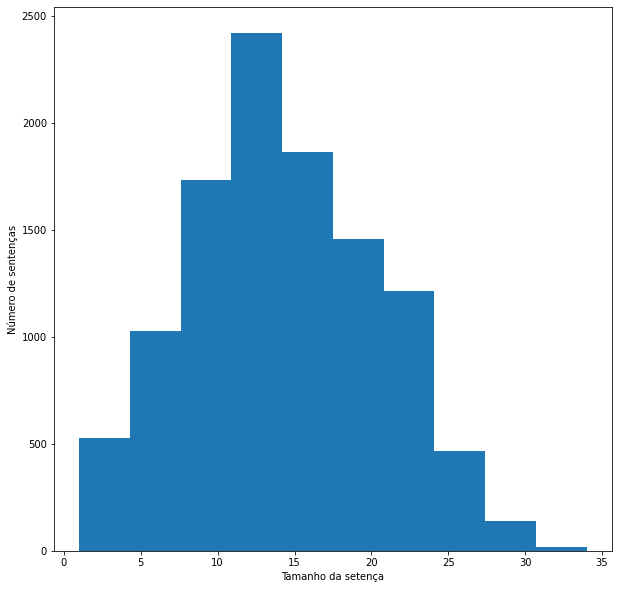

In [51]:
#Distribuilção das sentenças por quantidade de palavras 
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Tamanho da setença') 
plt.ylabel('Número de sentenças') 
plt.hist(sentence_lengths) 
plt.show()

In [52]:
# Construindo bag-of-words com count-vectorizer 
count_vectorizer = CountVectorizer() 
# Separando o texto da variável alvo 
list_corpus = clean_questions["text"].tolist() 
list_labels = clean_questions["class_label"].tolist() 
# Construindo exemplos para treinamento e teste 
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)                                                           
# Aprendendo o vacabulário e contabilizando os termos para teste 
X_train_counts = count_vectorizer.fit_transform(X_train) 
# Contabilizando os termos no vocabulário aprendido para treino 
X_test_counts = count_vectorizer.transform(X_test)

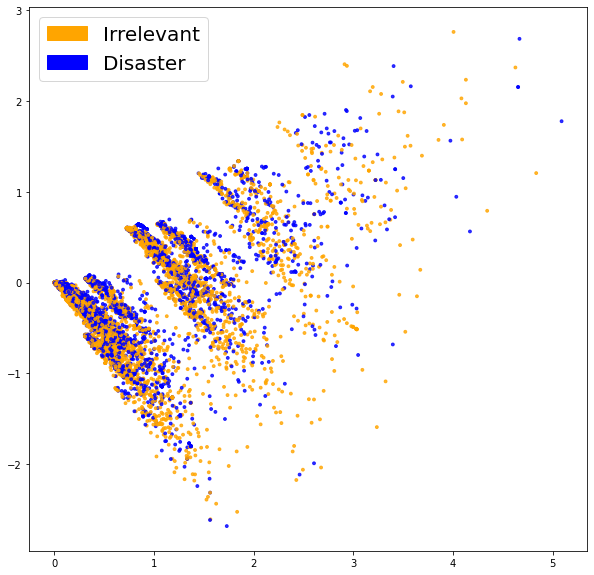

In [62]:
# Método para plotar o gráfico com a distribuição do vocabulário por variável alvo 
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)        
        lsa.fit(test_data)        
        lsa_scores = lsa.transform(test_data)        
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}        
        color_column = [color_mapper[label] for label in test_labels]        
        colors = ['orange','blue','blue']        
        if plot:            
           plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
           red_patch = mpatches.Patch(color='orange', label='Irrelevant')            
           green_patch = mpatches.Patch(color='blue', label='Disaster')           
           plt.legend(handles=[red_patch, green_patch], prop={'size': 20})   

fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train) 
plt.show()

In [54]:
# Aplicando configurações no modelo 
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',multi_class='multinomial', n_jobs=-1, random_state=40) 
#Treinando o modelo com o vocabulário construindo e as variáveis alvo 
clf.fit(X_train_counts, y_train) 
#Realizando as predições para o conjunto de teste 
y_predicted_counts = clf.predict(X_test_counts)

In [55]:
# Método para extração das métricas de avaliação usando a parte dos dados que separamos para teste. 
def get_metrics(y_test, y_predicted):      
   # true positives / (true positives+false positives)    
   precision = precision_score(y_test, y_predicted, pos_label=None,average='weighted')                 
   # true positives / (true positives + false negatives)    
   recall = recall_score(y_test, y_predicted, pos_label=None,average='weighted')        
   # harmonic mean of precision and recall    
   f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')        
   # true positives + true negatives/ total    
   accuracy = accuracy_score(y_test, y_predicted)    
   return accuracy, precision, recall, f1 
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.754, precision = 0.752, recall = 0.754, f1 = 0.753


In [65]:
#Método para plotar a matriz de confusão. 
def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix', cmap=plt.cm.winter): 
    if normalize:        
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)    
    plt.title(title, fontsize=30)    
    plt.colorbar()    
    tick_marks = np.arange(len(classes))    
    plt.xticks(tick_marks, classes, fontsize=20)    
    plt.yticks(tick_marks, classes, fontsize=20)        
    fmt = '.2f' if normalize else 'd'    
    thresh = cm.max() / 2.     
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):        
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()   
    plt.ylabel('True label', fontsize=30)    
    plt.xlabel('Predicted label', fontsize=30)
    return plt

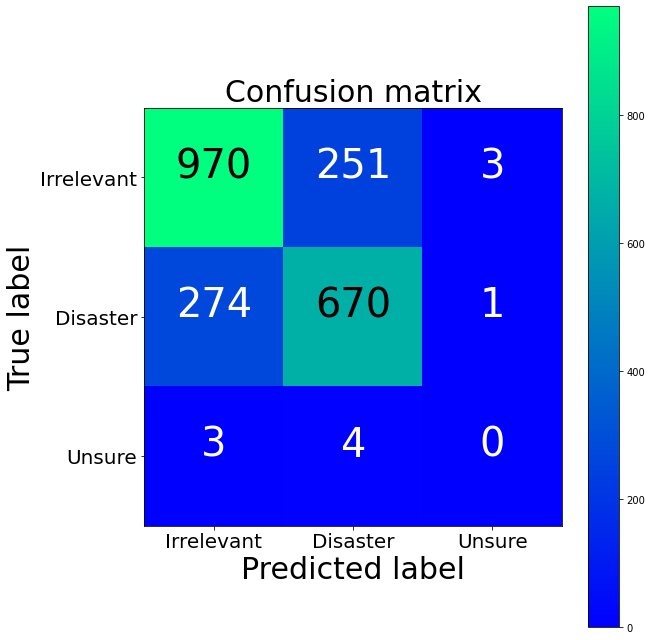

Count Vectorizer confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [66]:
cm = confusion_matrix(y_test, y_predicted_counts) 
fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix') 
plt.show() 
print("Count Vectorizer confusion matrix") 
print(cm)

In [58]:
# Método para identificação das features mais importantes na tomada de decisão. 
def get_most_important_features(vectorizer, model, n=5):    
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}        
    # loop for each class    
    classes ={}    
    for class_index in range(model.coef_.shape[0]):        
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]        
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)        
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])        
        bottom = sorted_coeff[-n:]        
        classes[class_index] = {'tops':tops,'bottom':bottom}    
    return classes 
importance = get_most_important_features(count_vectorizer, clf, 10)

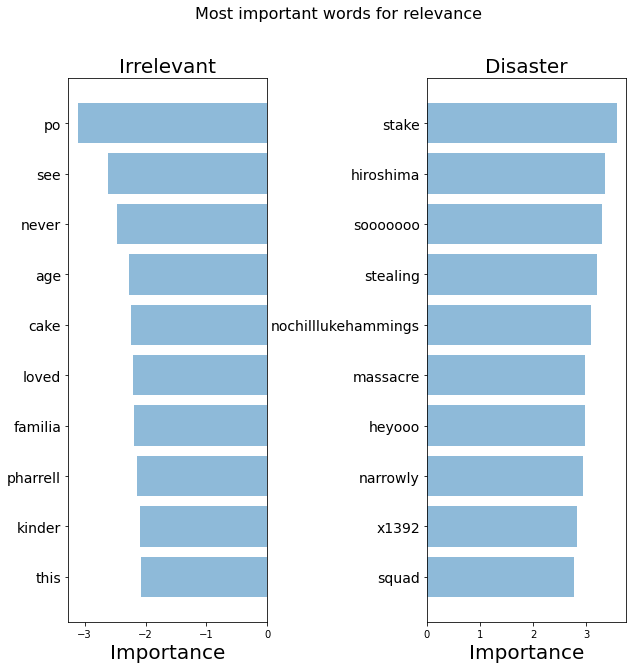

In [59]:
# Método para plotar as featrues mais importantes para cada variável alvo. 
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):    
    y_pos = np.arange(len(top_words))    
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]    
    top_pairs = sorted(top_pairs, key=lambda x: x[1])        
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]    
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)        
    top_words = [a[0] for a in top_pairs]    
    top_scores = [a[1] for a in top_pairs]        
    bottom_words = [a[0] for a in bottom_pairs]    
    bottom_scores = [a[1] for a in bottom_pairs]        
    fig = plt.figure(figsize=(10, 10))      
    plt.subplot(121)    
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)    
    plt.title('Irrelevant', fontsize=20)    
    plt.yticks(y_pos, bottom_words, fontsize=14)    
    plt.suptitle('Key words', fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplot(122)    
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)    
    plt.title('Disaster', fontsize=20)    
    plt.yticks(y_pos, top_words, fontsize=14)    
    plt.suptitle(name, fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplots_adjust(wspace=0.8)    
    plt.show() 
top_scores = [a[0] for a in importance[1]['tops']] 
top_words = [a[1] for a in importance[1]['tops']] 
bottom_scores = [a[0] for a in importance[1]['bottom']] 
bottom_words = [a[1] for a in importance[1]['bottom']] 
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

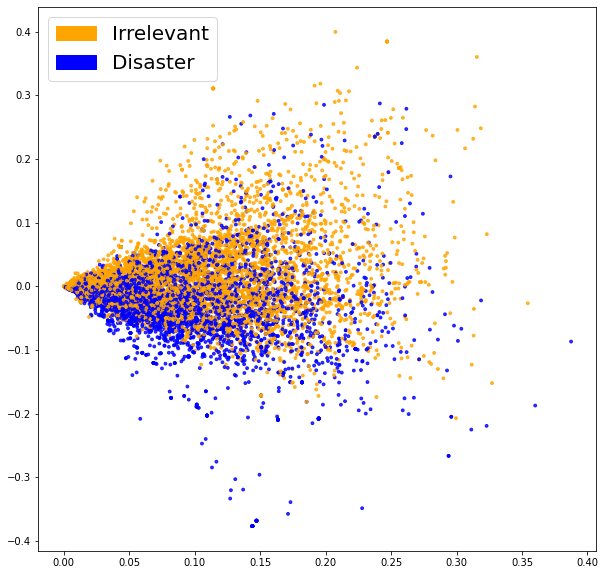

In [67]:
# Construindo bag-of-words com count-vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Aprendendo o vacabulário e contabilizando os termos para teste
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Contabilizando os termos no vocabulário aprendido para treino
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Plotando a distribuição do vocabulário
fig = plt.figure(figsize=(10, 10))
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [68]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',                          multi_class='multinomial', n_jobs=-1, random_state=40) 
#Treinando o modelo com o vocabulário construindo e as variáveis alvo 
clf_tfidf.fit(X_train_tfidf, y_train) 
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [69]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf,recall_tfidf, f1_tfidf))

accuracy = 0.762, precision = 0.760, recall = 0.762, f1 = 0.761


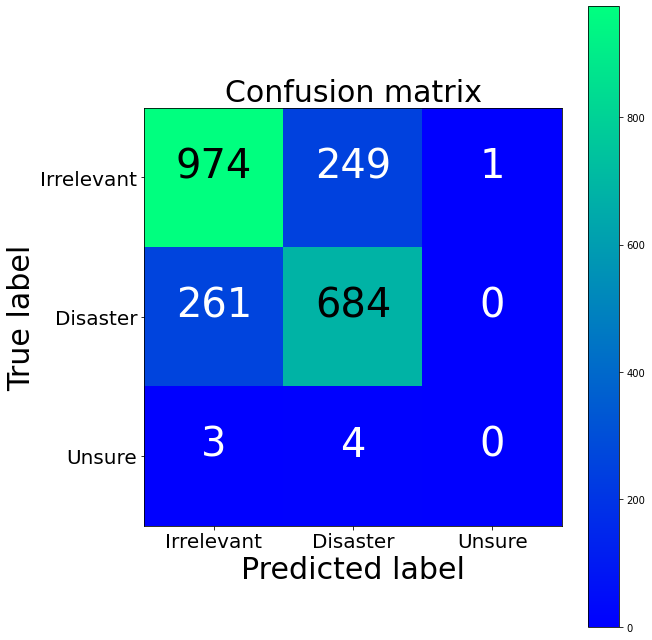

TFIDF confusion matrix
[[974 249   1]
 [261 684   0]
 [  3   4   0]]
BoW confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [71]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf) 
fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix') 
plt.show() 
print("TFIDF confusion matrix") 
print(cm2)
print("BoW confusion matrix") 
print(cm)

In [72]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

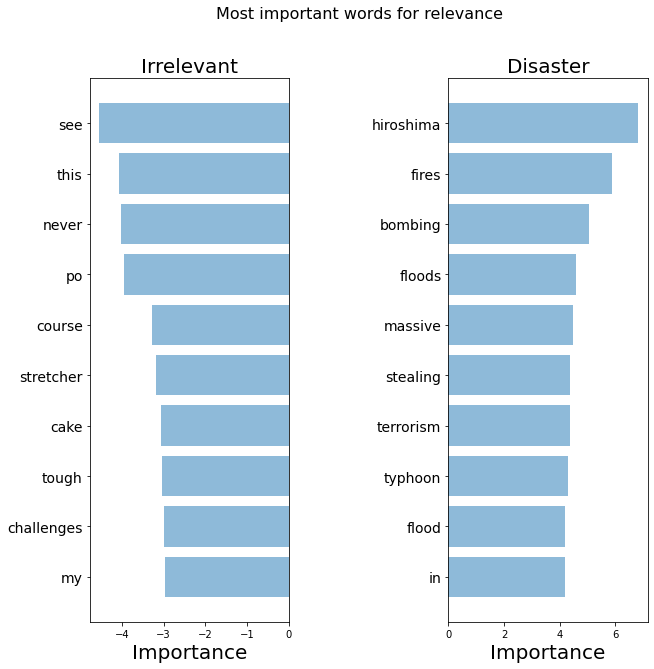

In [73]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']] 
top_words = [a[1] for a in importance_tfidf[1]['tops']] 
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']] 
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']] 
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [82]:
#Treinando a matriz de relação com notícias do Google 
#O conjunto de dados para treinar a matriz pode ser acessado em: #https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit word2vec_path = "GoogleNews-vectors-negative300.bin.gz" 

word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300 (1).bin.gz', binary=True)

In [83]:
#Método para calcular a distância semântica entre as palavras 
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):    
    if len(tokens_list)<1:        
       return np.zeros(k)    
    if generate_missing:        
       vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]    
    else:        
       vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]    
    length = len(vectorized)    
    summed = np.sum(vectorized, axis=0)    
    averaged = np.divide(summed, length)    
    return averaged 
#Montagem do arquivo de treinamento contento a relação semântica entre as palavras 
def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):    
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,generate_missing=generate_missing))    
    return list(embeddings)

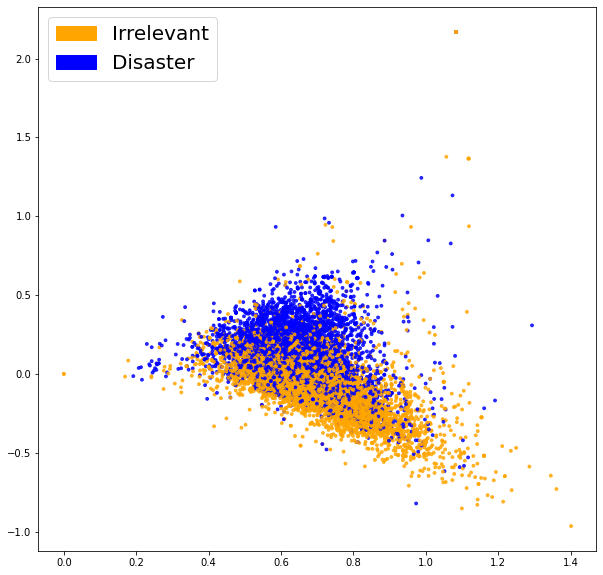

In [85]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions) 
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,test_size=0.2, random_state=40) 
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels) 
plt.show()

In [86]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',multi_class='multinomial', random_state=40) 
clf_w2v.fit(X_train_word2vec, y_train_word2vec) 
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [87]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec,recall_word2vec, f1_word2vec))

accuracy = 0.777, precision = 0.776, recall = 0.777, f1 = 0.777


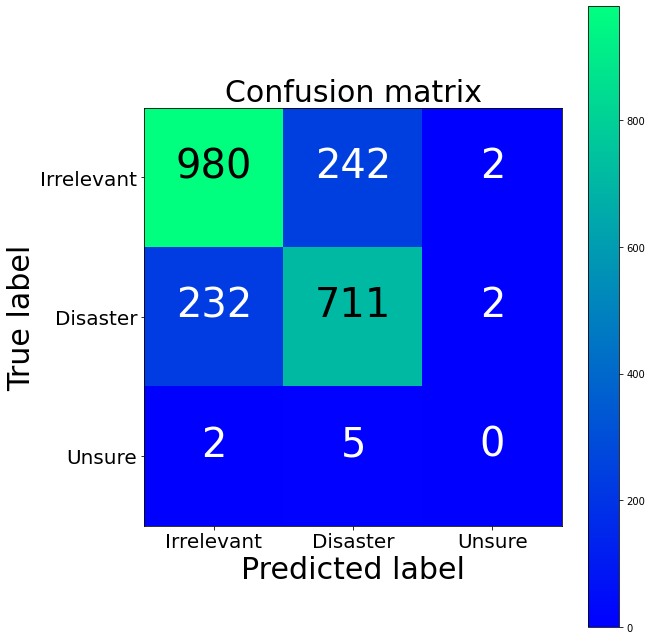

Word2Vec confusion matrix
[[980 242   2]
 [232 711   2]
 [  2   5   0]]
TFIDF confusion matrix
[[974 249   1]
 [261 684   0]
 [  3   4   0]]
BoW confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [90]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec) 
fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm_w2v, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show() 
print("Word2Vec confusion matrix") 
print(cm_w2v) 
print("TFIDF confusion matrix") 
print(cm2) 
print("BoW confusion matrix") 
print(cm)

#Tokenização e segmentação de sentenças
A tokenização e a segmentação da palavras podem ser realizadas com a lib Stanza, as quais são executadas em conjunto pelo TokenizeProcessor. Este processador divide o texto de entrada  em tokens e frases. Este processador pode ser chamado pela função tokenize.

In [2]:
pip install stanza


     |████████████████████████████████| 574 kB 12.7 MB/s 
     |████████████████████████████████| 175 kB 78.6 MB/s 
     |████████████████████████████████| 4.0 MB 62.7 MB/s 
     |████████████████████████████████| 6.6 MB 51.9 MB/s 
     |████████████████████████████████| 596 kB 53.6 MB/s 
     |████████████████████████████████| 895 kB 31.1 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=f246e50a3546e99ba8fd6eb8a29f0b84229336e8f29f6fb9f05f42102b1dd3d9
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [93]:
import stanza 
nlp = stanza.Pipeline(lang='en', processors='tokenize') 
doc = nlp('This is a test sentence for stanza. This is another sentence.') 
for i, sentence in enumerate(doc.sentences):     
    print(f'====== Sentence {i+1} tokens =======')     
    print(*[f'id: {token.id}\ttext: {token.text}' for token in sentence.tokens], sep='\n')

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Done loading processors!


====== Sentence 1 tokens =======
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: a
id: (4,)	text: test
id: (5,)	text: sentence
id: (6,)	text: for
id: (7,)	text: stanza
id: (8,)	text: .
====== Sentence 2 tokens =======
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: another
id: (4,)	text: sentence
id: (5,)	text: .


In [94]:
#Para acessar somente a segmentação de sentenças é possível fazendo:
print([sentence.text for sentence in doc.sentences])

['This is a test sentence for stanza.', 'This is another sentence.']


In [95]:

nlp = stanza.Pipeline(lang='en', processors='tokenize', tokenize_no_ssplit=True)
doc = nlp('This is a sentence.\n\nThis is a second. This is a third.')
for i, sentence in enumerate(doc.sentences):
    print(f'====== Sentence {i+1} tokens =======')
    print(*[f'id: {token.id}\ttext: {token.text}' for token in sentence.tokens], sep='\n')

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Done loading processors!


====== Sentence 1 tokens =======
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: a
id: (4,)	text: sentence
id: (5,)	text: .
====== Sentence 2 tokens =======
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: a
id: (4,)	text: second
id: (5,)	text: .
id: (6,)	text: This
id: (7,)	text: is
id: (8,)	text: a
id: (9,)	text: third
id: (10,)	text: .


Processar texto pré-tokenizado

In [97]:

nlp = stanza.Pipeline(lang='en', processors='tokenize', tokenize_pretokenized=True)
doc = nlp('This is token.ization done my way!\nSentence split, too!')
for i, sentence in enumerate(doc.sentences):
    print(f'====== Sentence {i+1} tokens =======')
    print(*[f'id: {token.id}\ttext: {token.text}' for token in sentence.tokens], sep='\n')

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Done loading processors!


====== Sentence 1 tokens =======
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: token.ization
id: (4,)	text: done
id: (5,)	text: my
id: (6,)	text: way!
====== Sentence 2 tokens =======
id: (1,)	text: Sentence
id: (2,)	text: split,
id: (3,)	text: too!


Um alternativa é utilziar uma lista de stings:

In [98]:
nlp = stanza.Pipeline(lang='en', processors='tokenize', tokenize_pretokenized=True)
doc = nlp([['This', 'is', 'token.ization', 'done', 'my', 'way!'], ['Sentence', 'split,', 'too!']])
for i, sentence in enumerate(doc.sentences):
    print(f'====== Sentence {i+1} tokens =======')
    print(*[f'id: {token.id}\ttext: {token.text}' for token in sentence.tokens], sep='\n')

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Done loading processors!


====== Sentence 1 tokens =======
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: token.ization
id: (4,)	text: done
id: (5,)	text: my
id: (6,)	text: way!
====== Sentence 2 tokens =======
id: (1,)	text: Sentence
id: (2,)	text: split,
id: (3,)	text: too!


#Lematização

Tem como objetivo reduzir uma palavra à sua forma base e agrupar diferentes formas da mesma palavra. Por exemplo, os verbos no tempo passado são alterados para presente (por exemplo, “foi” é alterado para “vai”) e os sinônimos são unificados (por exemplo, “melhor” é alterado para “bom”), padronizando palavras com significado semelhante à sua raiz.   



In [3]:
import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')
doc = nlp('Barack Obama was born in Hawaii.')
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')

2022-04-29 18:38:41 WARNING: Can not find mwt: default from official model list. Ignoring it.


2022-04-29 18:38:46 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

2022-04-29 18:38:46 INFO: Use device: cpu
2022-04-29 18:38:46 INFO: Loading: tokenize
2022-04-29 18:38:46 INFO: Loading: pos
2022-04-29 18:38:47 INFO: Loading: lemma
2022-04-29 18:38:47 INFO: Done loading processors!


word: Barack 	lemma: Barack
word: Obama 	lemma: Obama
word: was 	lemma: be
word: born 	lemma: bear
word: in 	lemma: in
word: Hawaii 	lemma: Hawaii
word: . 	lemma: .


#Análise de sentimentos com NLTK